In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
import RK4_numba as RK4

/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/tensorf

In [2]:
r = RK4.Rocket()

dAngle = 0.05*np.pi
dThrottle = 0.05
dt = 0.1

#R = []
#RX = []
#RY = []
#V = []
#Fuel = []

def step(r, action):
    pt_vars = np.array([r.rx, r.ry, r.vx, r.vy, r.fuelm], dtype=np.float32)
    
    angle, throttle, staged = r.input_vars
    
    if action == 0:
        angle += dAngle
        throttle += dThrottle
    elif action == 1:
        angle -= dAngle
        throttle += dThrottle
    elif action == 2:
        angle += dAngle
        throttle -= dThrottle
    elif action == 3:
        angle -= dAngle
        throttle -= dThrottle
    elif action == 4:
        angle = angle
        throttle = throttle
    else:
        print("NO ACTION SELECTED")
        
    if throttle > 1:
        throttle = 1
    elif throttle < 0:
        throttle = 0

    
    #OUT OF FUEL
    if r.fuelm <= 0:
        print("Out Of Fuel")
        done = True
    #CRASHES
    elif np.sqrt(r.rx**2+r.ry**2) < r.sea:
        print("Crashed")
        done = True
    #TIME CUTOFF
    elif r.t > 100000:
        print("Time Limit")
        done = True
    #ACHIEVE ORBIT HERE DON"T FORGET TO INCLUDE THIS HERE 
    else:
        done = False
        
    r.input_vars = np.array([angle, throttle, staged], dtype=np.float32)
    r.RK4_step(pt_vars, dt, r.input_vars)
    
    return r, done

'''
actions = {
(+throttle, +angle),
(+throttle, -angle),
(-throttle, +angle),
(-throttle, -angle),
(do nothing)
}
'''

def reward(state):
    rx, ry, vx, vy, m, has_staged = state[0]
    
    x = np.sqrt(rx**2+ry**2)
    v = np.sqrt(vx**2+vy**2)
    
    rw_x = 1/(1+np.exp(-0.00004*(x-r.karman)))
    rw_v = 1/(1+np.exp(-0.001*(v-7790/2)))
    rw_m = 0  #0.1*m/r.mi
    
    punish = 0
    if np.sqrt(r.rx**2+r.ry**2) < r.sea:
        punish = -2
    
    return rw_x + rw_v + rw_m + punish

In [3]:
inputs = keras.Input(shape=(6))
x = keras.layers.Dense(16, activation="relu")(inputs)
x = keras.layers.Dense(32, activation="relu")(x)
outputs = keras.layers.Dense(5, activation=None)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
epochs = 2000
greed = 0.5
greed_decay = 0.999
discount_factor = 0.9

all_RX = []
all_RY = []
all_rewards =[]

for i in range(epochs):
    print("EPOCH: ", i)
    r = RK4.Rocket()
    state = np.array([[r.rx, r.ry, r.vx, r.vy, r.m, int(r.has_staged)]])
    greed *= greed_decay
    
    RX = []
    RY = []
    rewards = []
    
    done = False
    while not done:
        if np.random.random() < greed:
            action = np.random.randint(0, 5)
        else:
            action = np.argmax(model.predict(state))
            
        RX.append(r.rx)
        RY.append(r.ry)
            
        r, done = step(r, action)
        new_state = np.array([[r.rx, r.ry, r.vx, r.vy, r.m, int(r.has_staged)]])
                
        target = reward(state) + discount_factor * np.max(model.predict(new_state))
        rewards.append(reward(state))
        
        target_vector = np.zeros(5)
        target_vector[action] = target
        model.fit(state, np.array([target_vector]), epochs=1, verbose=0)
        state = new_state
        if done:
            print(reward(state))
        
    all_rewards.append(max(rewards))
    if i % 100 == 0:
        all_RX.append(RX)
        all_RY.append(RY)
        

EPOCH:  0
Crashed
-1.9614675618111845
EPOCH:  1
Crashed
-1.960860195645235
EPOCH:  2
Crashed
-1.9605315982773035
EPOCH:  3
Crashed
-1.9614843954153
EPOCH:  4
Crashed
-1.9592084260278115
EPOCH:  5
Crashed
-1.9607778869717478
EPOCH:  6
Crashed
-1.9607002152736244
EPOCH:  7
Crashed
-1.9601798534830916
EPOCH:  8
Crashed
-1.9597033795182344
EPOCH:  9
Crashed
-1.9585879417305425
EPOCH:  10
Crashed
-1.9577637569052768
EPOCH:  11
Crashed
-1.9597534032975075
EPOCH:  12
Crashed
-1.9588992265199274
EPOCH:  13
Crashed
-1.9578756307916105
EPOCH:  14
Crashed
-1.9600651304656476
EPOCH:  15
Crashed
-1.9579865875902658
EPOCH:  16
Crashed
-1.9597027018727011
EPOCH:  17
Crashed
-1.960054004665862
EPOCH:  18
Crashed
-1.959977792879004
EPOCH:  19
Crashed
-1.960823616111654
EPOCH:  20
Crashed
-1.9607970148164273
EPOCH:  21
Crashed
-1.9606183932466739
EPOCH:  22
Crashed
-1.9554411943400756
EPOCH:  23
Crashed
-1.9608797298378586
EPOCH:  24
Crashed
-1.9606904202799154
EPOCH:  25
Crashed
-1.9612069564028787
EPO

Crashed
-1.960964844801675
EPOCH:  210
Crashed
-1.9607287163911147
EPOCH:  211
Crashed
-1.9611996789859174
EPOCH:  212
Crashed
-1.9612520481059974
EPOCH:  213
Crashed
-1.9607530718451531
EPOCH:  214
Crashed
-1.9590252194451698
EPOCH:  215
Crashed
-1.9610714426576286
EPOCH:  216
Crashed
-1.961051101702497
EPOCH:  217
Crashed
-1.9610781799721944
EPOCH:  218
Crashed
-1.9609831403762528
EPOCH:  219
Crashed
-1.960119296247126
EPOCH:  220
Crashed
-1.9613434605306084
EPOCH:  221
Crashed
-1.9613458541564626
EPOCH:  222
Crashed
-1.9596344215693584
EPOCH:  223
Crashed
-1.9609030867019128
EPOCH:  224
Crashed
-1.9611565557724826
EPOCH:  225
Crashed
-1.9611493272757006
EPOCH:  226
Crashed
-1.9598959403900693
EPOCH:  227
Crashed
-1.9612587778702346
EPOCH:  228
Crashed
-1.9606070652616288
EPOCH:  229
Crashed
-1.9611374200644656
EPOCH:  230
Crashed
-1.9613052951565926
EPOCH:  231
Crashed
-1.9591248666068632
EPOCH:  232
Crashed
-1.96102802182361
EPOCH:  233
Crashed
-1.9613492374245565
EPOCH:  234
Crash

Crashed
-1.9611263051989452
EPOCH:  416
Crashed
-1.9613523449096022
EPOCH:  417
Crashed
-1.9613950819300199
EPOCH:  418
Crashed
-1.9603419047256345
EPOCH:  419
Crashed
-1.9609570929170776
EPOCH:  420
Crashed
-1.961115728552195
EPOCH:  421
Crashed
-1.961159896561238
EPOCH:  422
Crashed
-1.961365535021119
EPOCH:  423
Crashed
-1.9613906385447262
EPOCH:  424
Crashed
-1.9610674261094343
EPOCH:  425
Crashed
-1.960782584274098
EPOCH:  426
Crashed
-1.9613575765763225
EPOCH:  427
Crashed
-1.960828539051178
EPOCH:  428
Crashed
-1.9610904710967612
EPOCH:  429
Crashed
-1.9605569918180352
EPOCH:  430
Crashed
-1.9609219445286339
EPOCH:  431
Crashed
-1.9613312995842473
EPOCH:  432
Crashed
-1.956578455716778
EPOCH:  433
Crashed
-1.9608224093297606
EPOCH:  434
Crashed
-1.961382044716658
EPOCH:  435
Crashed
-1.9609983043876107
EPOCH:  436
Crashed
-1.9609113431330412
EPOCH:  437
Crashed
-1.9609369467054505
EPOCH:  438
Crashed
-1.960620577681099
EPOCH:  439
Crashed
-1.961820960251608
EPOCH:  440
Crashed
-

Crashed
-1.961456476571833
EPOCH:  623
Crashed
-1.9613130485659223
EPOCH:  624
Crashed
-1.9613209321035268
EPOCH:  625
Crashed
-1.9614002524400758
EPOCH:  626
Crashed
-1.961221604518986
EPOCH:  627
Crashed
-1.9605563205076764
EPOCH:  628
Crashed
-1.9608937480075226
EPOCH:  629
Crashed
-1.9613906716329657
EPOCH:  630
Crashed
-1.9609382965000883
EPOCH:  631
Crashed
-1.9606246278899584
EPOCH:  632
Crashed
-1.9609352292012112
EPOCH:  633
Crashed
-1.9611443617688908
EPOCH:  634
Crashed
-1.9611477999954723
EPOCH:  635
Crashed
-1.9608553910937347
EPOCH:  636
Crashed
-1.9612180054656565
EPOCH:  637
Crashed
-1.9610794999514367
EPOCH:  638
Crashed
-1.9610251306870707
EPOCH:  639
Crashed
-1.961181197317297
EPOCH:  640
Crashed
-1.96119722124554
EPOCH:  641
Crashed
-1.9612839703527667
EPOCH:  642
Crashed
-1.9612304346793064
EPOCH:  643
Crashed
-1.9613256758548672
EPOCH:  644
Crashed
-1.9612887894431408
EPOCH:  645
Crashed
-1.9614735369972938
EPOCH:  646
Crashed
-1.9614436463824065
EPOCH:  647
Crash

Crashed
-1.9614562295385443
EPOCH:  831
Crashed
-1.9614562295385443
EPOCH:  832
Crashed
-1.9614562295385443
EPOCH:  833
Crashed
-1.9614562295385443
EPOCH:  834
Crashed
-1.9614562295385443
EPOCH:  835
Crashed
-1.9614562295385443
EPOCH:  836
Crashed
-1.9614562295385443
EPOCH:  837
Crashed
-1.9614562295385443
EPOCH:  838
Crashed
-1.9614562295385443
EPOCH:  839
Crashed
-1.9614562295385443
EPOCH:  840
Crashed
-1.9614562295385443
EPOCH:  841
Crashed
-1.9614562295385443
EPOCH:  842
Crashed
-1.9614562295385443
EPOCH:  843
Crashed
-1.9614562295385443
EPOCH:  844
Crashed
-1.9614562295385443
EPOCH:  845
Crashed
-1.9614562295385443
EPOCH:  846
Crashed
-1.9614562295385443
EPOCH:  847
Crashed
-1.9614562295385443
EPOCH:  848
Crashed
-1.9614562295385443
EPOCH:  849
Crashed
-1.9614562295385443
EPOCH:  850
Crashed
-1.9614562295385443
EPOCH:  851
Crashed
-1.9614562295385443
EPOCH:  852
Crashed
-1.9614562295385443
EPOCH:  853
Crashed
-1.9614562295385443
EPOCH:  854
Crashed
-1.9614562295385443
EPOCH:  855


Crashed
-1.9614562295368334
EPOCH:  1036
Crashed
-1.9614151199494385
EPOCH:  1037
Crashed
-1.9614683192899756
EPOCH:  1038
Crashed
-1.9615715207519406
EPOCH:  1039
Crashed
-1.9614658168970767
EPOCH:  1040
Crashed
-1.9614562295368334
EPOCH:  1041
Crashed
-1.9614562295368334
EPOCH:  1042
Crashed
-1.9615104873299325
EPOCH:  1043
Crashed
-1.9614947833612233
EPOCH:  1044
Crashed
-1.9614562295368334
EPOCH:  1045
Crashed
-1.9614562295385443
EPOCH:  1046
Crashed
-1.9614564159116856
EPOCH:  1047
Crashed
-1.9614562668065443
EPOCH:  1048
Crashed
-1.9614151199494385
EPOCH:  1049
Crashed
-1.9614562295368334
EPOCH:  1050
Crashed
-1.9614167105399383
EPOCH:  1051
Crashed
-1.9614566949930894
EPOCH:  1052
Crashed
-1.9614570047379358
EPOCH:  1053
Crashed
-1.9614151274599396
EPOCH:  1054
Crashed
-1.9614562295368334
EPOCH:  1055
Crashed
-1.9614151198817562
EPOCH:  1056
Crashed
-1.9614570047379358
EPOCH:  1057
Crashed
-1.961727700097414
EPOCH:  1058
Crashed
-1.9614571320415315
EPOCH:  1059
Crashed
-1.961457

Crashed
-1.9614574022645657
EPOCH:  1238
Crashed
-1.9614574022645657
EPOCH:  1239
Crashed
-1.9614574022645657
EPOCH:  1240
Crashed
-1.9614574022645657
EPOCH:  1241
Crashed
-1.9614574022645657
EPOCH:  1242
Crashed
-1.9614574022645657
EPOCH:  1243
Crashed
-1.9614574022645657
EPOCH:  1244
Crashed
-1.9614574022645657
EPOCH:  1245
Crashed
-1.9614574022645657
EPOCH:  1246
Crashed
-1.9614574022645657
EPOCH:  1247
Crashed
-1.9614574022645657
EPOCH:  1248
Crashed
-1.9614574022645657
EPOCH:  1249
Crashed
-1.9614574022645657
EPOCH:  1250
Crashed
-1.9614574022645657
EPOCH:  1251
Crashed
-1.9614574022645657
EPOCH:  1252
Crashed
-1.9614574022645657
EPOCH:  1253
Crashed
-1.9614574022645657
EPOCH:  1254
Crashed
-1.9614574022645657
EPOCH:  1255
Crashed
-1.9614574022645657
EPOCH:  1256
Crashed
-1.9614574022645657
EPOCH:  1257
Crashed
-1.9614574022645657
EPOCH:  1258
Crashed
-1.9614574022645657
EPOCH:  1259
Crashed
-1.9614574022645657
EPOCH:  1260
Crashed
-1.9614574022645657
EPOCH:  1261
Crashed
-1.96145

Crashed
-1.9614574022645657
EPOCH:  1439
Crashed
-1.9614574022645657
EPOCH:  1440
Crashed
-1.9614574022645657
EPOCH:  1441
Crashed
-1.9614574022645657
EPOCH:  1442
Crashed
-1.9614574022645657
EPOCH:  1443
Crashed
-1.9614574022645657
EPOCH:  1444
Crashed
-1.9614574022645657
EPOCH:  1445
Crashed
-1.9614574022645657
EPOCH:  1446
Crashed
-1.9614574022645657
EPOCH:  1447
Crashed
-1.9614574022645657
EPOCH:  1448
Crashed
-1.9614574022645657
EPOCH:  1449
Crashed
-1.9614574022645657
EPOCH:  1450
Crashed
-1.9614574022645657
EPOCH:  1451
Crashed
-1.9614574022645657
EPOCH:  1452
Crashed
-1.9614574022645657
EPOCH:  1453
Crashed
-1.9614574022645657
EPOCH:  1454
Crashed
-1.9614574022645657
EPOCH:  1455
Crashed
-1.9614574022645657
EPOCH:  1456
Crashed
-1.9614574022645657
EPOCH:  1457
Crashed
-1.9614574022645657
EPOCH:  1458
Crashed
-1.9614574022645657
EPOCH:  1459
Crashed
-1.9614574022645657
EPOCH:  1460
Crashed
-1.9614574022645657
EPOCH:  1461
Crashed
-1.9614574022645657
EPOCH:  1462
Crashed
-1.96145

Crashed
-1.9614574022645657
EPOCH:  1640
Crashed
-1.9614574022645657
EPOCH:  1641
Crashed
-1.9614574022645657
EPOCH:  1642
Crashed
-1.9614574022645657
EPOCH:  1643
Crashed
-1.9614574022645657
EPOCH:  1644
Crashed
-1.9614574022645657
EPOCH:  1645
Crashed
-1.9614574022645657
EPOCH:  1646
Crashed
-1.9614574022645657
EPOCH:  1647
Crashed
-1.9614574022645657
EPOCH:  1648
Crashed
-1.9614574022645657
EPOCH:  1649
Crashed
-1.9614574022645657
EPOCH:  1650
Crashed
-1.9614574022645657
EPOCH:  1651
Crashed
-1.9614574022645657
EPOCH:  1652
Crashed
-1.9614574022645657
EPOCH:  1653
Crashed
-1.9614574022645657
EPOCH:  1654
Crashed
-1.961415127455881
EPOCH:  1655
Crashed
-1.9614562295385443
EPOCH:  1656
Crashed
-1.9614562295385443
EPOCH:  1657
Crashed
-1.9614562295385443
EPOCH:  1658
Crashed
-1.9614562295385443
EPOCH:  1659
Crashed
-1.9614562295385443
EPOCH:  1660
Crashed
-1.9614562295385443
EPOCH:  1661
Crashed
-1.9614562295385443
EPOCH:  1662
Crashed
-1.9614562295385443
EPOCH:  1663
Crashed
-1.961456

Out Of Fuel
1.7453003146089452
EPOCH:  1836
Out Of Fuel
1.7453003146089452
EPOCH:  1837
Out Of Fuel
1.7453003146089452
EPOCH:  1838
Out Of Fuel
1.7453003146089452
EPOCH:  1839
Out Of Fuel
1.7453003146089452
EPOCH:  1840
Out Of Fuel
1.7453003146089452
EPOCH:  1841
Out Of Fuel
1.7453003146089452
EPOCH:  1842
Out Of Fuel
1.7453003146089452
EPOCH:  1843
Out Of Fuel
1.7453003146089452
EPOCH:  1844
Out Of Fuel
1.7453003146089452
EPOCH:  1845
Out Of Fuel
1.7453003146089452
EPOCH:  1846
Out Of Fuel
1.7453003146089452
EPOCH:  1847
Out Of Fuel
1.7453003146089452
EPOCH:  1848
Out Of Fuel
1.7453003146089452
EPOCH:  1849
Out Of Fuel
1.7453003146089452
EPOCH:  1850
Out Of Fuel
1.7453003146089452
EPOCH:  1851
Out Of Fuel
1.7453003146089452
EPOCH:  1852
Out Of Fuel
1.7453003146089452
EPOCH:  1853
Out Of Fuel
1.7453003146089452
EPOCH:  1854
Out Of Fuel
1.7453003146089452
EPOCH:  1855
Out Of Fuel
1.7453003146089452
EPOCH:  1856
Out Of Fuel
1.7453003146089452
EPOCH:  1857
Out Of Fuel
1.7453003146089452
E

/Users/thomasdixon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


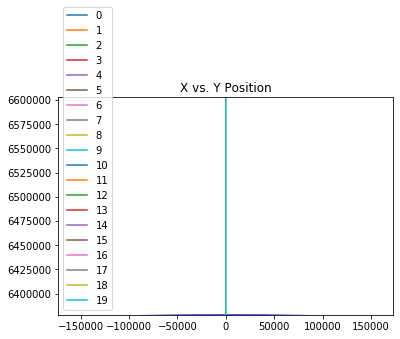

In [5]:
#NEED TO PLOT SOMETHING TO SHOW PROGRESS
all_RX = np.array(all_RX)
all_RY = np.array(all_RY)


rad = 6378000
surface = plt.Circle((0, 0), rad, color='b', fill=False)
#karman = rad + 100000

ax = plt.gca()
for i in range(len(all_RX)):
    plt.plot(all_RX[i], all_RY[i], label=f"{i}")
    
ax.add_patch(surface)
plt.xlim(min([min(i) for i in all_RX]), max([max(i) for i in all_RX]))
plt.ylim(min([min(i) for i in all_RY]), max([max(i) for i in all_RY]))
plt.title("X vs. Y Position")
plt.axes().set_aspect('equal','datalim')
plt.legend()
plt.show()

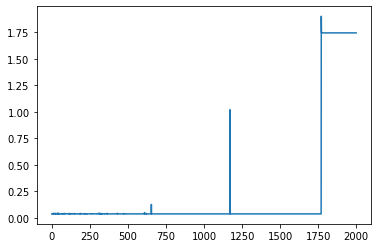

In [6]:
plt.plot(all_rewards)

In [8]:
model.predict(state)

array([[-2.6936958e-35, -2.4634206e-35,  2.7294204e-35,  2.0622952e-35,
         4.4321489e+00]], dtype=float32)